In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_sparse_coded_signal
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from timeit import default_timer as timer

I will use the terminology adopted in FW_survey paper. A will be an m x n matrix with the observations. b is the vector that contains the targets. We will try to learn a sparse linear combination of the features of A (Ax) that approximates b.

In [2]:
class Frank_Wolfe():
    """
    Implementation of Frank Wolfe algorithms for LASSO regression problems. 
    Classic and aways steps variations are currently implemented. 
    the class utilizes the fit() method to fit a dataset and produces a sparse solution vector x based on 
    the data and the parameters utilized.
    """

    def __init__(self, tau, iter=100, verbose=True, plots=True, delta=0.5, gamma=0.25, max_alpha=1,
                  min_alpha = 1e-10, alpha_search='diminishing', alg='original', e=1e-10):
        """
        Initializes a model based on the parameters given. 

        Args:
            tau: regulates the amount of shrinkage. low tau means high shrinkage and sparser solution
            iter: maximum number of iterations
            verbose: whether or not to display iteration-by-iteration informations during fitting
            plots: whether or not to display plots after fitting
            delta: delta parameter for armijo line search
            gamma: gamma parameter for armijo line search
            max_alpha: alpha parameter for armijo line search
            min_alpha: minimum stepsize for armijo line search
            alpha_search: type of stepsize (currently implemented diminishing or armijo)
            alg: type of FW algorithm (currently implemented original and away-steps)
            e: epsilon parameter for FW, indicates stopping criterion based on duality gap 

        Raises:
            ValueError: in case values for alg or alpha_search parameters are inserted wrongly
        """
        self.tau = tau
        self.iter = iter
        self.iter_final = 0
        self.verbose = verbose
        self.plots = plots
        self.delta = delta
        self.gamma = gamma
        self.max_alpha = max_alpha
        self.min_alpha = min_alpha
        self.e = e

        alg_types = ['original', 'away-steps']
        if alg not in alg_types:
            raise ValueError("Invalid alorithm name type. Expected one of: %s" % alg_types)
        self.alg = alg

        alpha_search_types = ['armijo', 'diminishing']
        if alpha_search not in alpha_search_types:
            raise ValueError("Invalid alpha_search type. Expected one of: %s" % alpha_search_types)
        self.alpha_search = alpha_search
    
    def fit(self, A, b):
        """
        Fits the dataset by providing a solution x using the selected variant of FW 
        Measures the CPU time for the execution of the algorithms and calls 

        Args:
            A: feature matrix 
            b: target vector
        """

        self.m, self.n = A.shape                        # number of training examples and features (atoms)
        self.x = np.zeros((self.n, 1))                  # initialize parameters vector
        self.E = np.identity(self.n); 
        self.A = A
        self.b = b
        self.b = self.b.reshape(-1, 1)

        self.sparse = np.zeros(self.iter)
        self.g = np.zeros(self.iter)
        self.objf = np.zeros(self.iter)

        start_t = time.process_time()

        if self.alg == 'original':
            self.FW()
        elif self.alg == 'away-steps':
            self.AFW()
        
        self.time = time.process_time() - start_t

        if self.plots:
            self.plot_results()

            
        return self

    def FW(self):
        """
        Executes FW classic method
        """
        for k in range(self.iter):
            self.grad = self.compute_gradient()             # compute gradient
            sk = self.LMO()                                 # calculate sk with LMO 
            dk = sk - self.x                                # calculate fw direction dk
            self.g[k] = dk.T.dot(-self.grad).item()         # calculate duality gap gk

            if self.g[k] < self.e:                          # if the FW is small enough, exit
                self.g = self.g[:k]
                self.sparse = self.sparse[:k]
                self.objf = self.objf[:k]
                self.iter_final= k
                return self
            
            self.objf[k] = self.f(self.x)

            if self.alpha_search == 'diminishing':          # classic diminishing stepsize as in jaggi (2013)
                alpha = 2 / (k + 2)  
            elif self.alpha_search == 'armijo': 
                alpha = self.armijo_alpha_search(dk)

            self.x = self.x + alpha * dk

            self.sparse[k] = sum(1 for x in self.x if abs(x) <= 0.0001) / len(self.x)
            if self.verbose:
                print("iteration:\t", k, "\t\t duality gap:\t", self.g[k], "\t\objective function:\t", self.objf[k])
        self.iter_final = self.iter
        return self
    
    def AFW(self): 
        """
        Executes away steps FW method
        """
        S = [(self.x, 1)]                                       # initialize active set with x(0)
        for k in range(self.iter):
            self.grad = self.compute_gradient()                 # compute gradient
            sk = self.LMO()                                     # calculate sk with LMO
            dfwk = sk - self.x                                  # calculate fw direction dk
            self.g[k] = dfwk.T.dot(-self.grad).item()           # calculate fw duality gap gk

            if self.g[k] < self.e:                              # if the FW is small enough, exit
                self.g = self.g[:k]
                self.sparse = self.sparse[:k]
                self.objf = self.objf[:k]
                self.iter_final = k
                return self
            
            self.objf[k] = self.f(self.x)
            
            vk = max(S, key=lambda v: np.dot(self.grad.T, v[0]))      # select away atom
            dAk = self.x - vk[0]                                    # calculate away direction

            if self.g[k] >= dAk.T.dot(-self.grad).item():
                fw = True
                dk = dfwk
                self.max_alpha = 1                                  
            else:
                fw = False
                dk = dAk
                self.max_alpha = vk[1] / (1 - vk[1])                # maximum feasible step-size for the away step 

            alpha = self.armijo_alpha_search(dk)
            
            self.x = self.x + alpha * dk                            # update parameters
            
            # Update the active set weights as in FW_variants paper text
            if fw:                                # if FW step
                if alpha == 1:
                    S = [(sk, alpha)]
                else:
                    found = False                                           # See if sk is already in the active set
                    for i, (atom, weight) in enumerate(S):
                        if np.array_equal(atom, sk):
                            S[i] = (atom, ((1 - alpha) * weight) + alpha)
                            found = True
                            break
                    if not found:
                        S.append((sk, alpha))
            
                    for i, (atom, weight) in enumerate(S):                  # Adjust the weights of other atoms
                        if not np.array_equal(atom, sk):
                            S[i] = (atom, (1 - alpha) * weight)
            else:                                                       # if Away step
                if alpha == self.max_alpha:                             # drop step
                    drop = True
                else:
                    drop = False
                for i, (atom, weight) in enumerate(S):                  # this is for active atom
                    if np.array_equal(atom, vk[0]):
                        if drop:                         # Drop step
                            S.pop(i)
                        else:
                            S[i] = (atom, ((1 + alpha) * weight) - alpha)
                        break
                for i, (atom, weight) in enumerate(S):                  # this updates the other atoms of the active set
                    if not np.array_equal(atom, vk[0]):
                        S[i] = (atom, (1 + alpha) * weight)

            self.sparse[k] = sum(1 for x in self.x if abs(x) <= 0.0001) / len(self.x)
            if self.verbose:
                print("iteration:\t", k, "\t\t duality gap:\t", self.g[k], "\t\objective function:\t", self.objf[k])

        self.iter_final = self.iter
        return self
    
    def armijo_alpha_search(self, dk):
        i = 0
        fx = self.f(self.x)                             # fx does not depend on alpha, so we can calculate outside of loop to increase efficiency
        grad_dk = np.dot(self.grad.T, dk).item()
        while True:
            alpha = np.power(self.delta, i) * self.max_alpha         # compute new stepsize
            if alpha < self.min_alpha:                                  # break cycle to avoid infinite loop possibility or too small alpha
                break
            
            xk = self.x + alpha * dk                                    
            fxk = self.f(xk)

            if fxk <= fx + self.gamma * alpha * grad_dk: # if armjio condition is satisfied
                break
            i += 1
        
        return alpha

    # compute gradient of f(x) = 1/2||Ax - b|| norm 2 squared, which is At(Ax - b)
    def compute_gradient(self):
        return self.A.T.dot(self.A.dot(self.x) - self.b)
    
    # compute f(x) = 1/2||Ax - b|| norm 2 squared
    def f(self, x):
        return 0.5 * np.linalg.norm(self.A.dot(x) - self.b, ord=2) ** 2
    
    # compute the LMO for the current iteration 
    def LMO(self):
        ik = np.argmax(np.abs(self.grad))                   # Index of gradient element with maximum absolute value
        return (np.sign(-self.grad[ik]) * self.tau *  self.E[:, ik]).reshape(-1, 1)

    def predict(self, A):
        return A.dot(self.x) 
    
    def plot_results(self):

        iterations = range(self.iter_final)

        logg = np.log10(self.g)
        logf = np.log10(self.objf)

        fig = plt.figure(figsize=(10, 13))
        gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 0.2])  # Adjust ratios as needed
    
        ax0 = plt.subplot(gs[0])
        ax0.plot(iterations, logg, color='blue', marker='.', linestyle='-', markersize=3, drawstyle='steps-post')
        ax0.set_title('Log Duality Gap (g) Over Iterations')
        ax0.set_xlabel('Iteration (k)')
        ax0.set_ylabel('Duality Gap log((g))')
        ax0.grid(True)
    
        ax1 = plt.subplot(gs[1])
        ax1.plot(iterations, logf, color='red', marker='.', linestyle='-', markersize=3, drawstyle='steps-post')
        ax1.set_title('log objective function Over Iterations')
        ax1.set_xlabel('Iteration (k)')
        ax1.set_ylabel('log(f(x))')
        ax1.grid(True)

        ax2 = plt.subplot(gs[2])
        ax2.plot(iterations, self.sparse, color='green', marker='.', linestyle='-', markersize=3, drawstyle='steps-post')
        ax2.set_title('Sparsity Over Iterations')
        ax2.set_xlabel('Iteration (k)')
        ax2.set_ylabel('Sparsity')
        ax2.grid(True)
    
        ax3 = plt.subplot(gs[3])
        sns.heatmap(self.x.T, ax=ax3, cbar=True, linecolor='white', linewidths=1, center=0)
        ax3.set_title('Heatmap of x Vector')
        ax3.set_xlabel('Features')
    
        plt.tight_layout()
        plt.show()

        print("Final duality gap: ", self.g[-1])
        print("Final objective function value: ", self.objf[-1])
        print("CPU time: ", self.time)
        print("iterations: ", len(iterations))
        print("Zero elements in x: ", sum(1 for x in self.x if abs(x) <= 0.0001))
        print("Sparsity: ", sum(1 for x in self.x if abs(x) <= 0.0001)/len(self.x))
        return
    
    def return_metrics(self):
        return self.iter_final, self.time, sum(1 for x in self.x if abs(x) <= 0.0001)/len(self.x)

    def compare(self, model2):
        if self.iter_final == 0:
            raise Exception("model1 is not fitted")
        if model2.iter_final == 0:
            raise Exception("model2 is not fitted")
        
        if self.iter_final >= model2.iter_final:
            iterations = self.iter_final
        else:
            iterations = model2.iter_final
        
        max_iter = max(self.iter_final, model2.iter_final)

        g1 = np.concatenate([self.g, np.full(max_iter - self.iter_final, np.nan)])              # make sure we have same lenght for both vectors
        g2 = np.concatenate([model2.g, np.full(max_iter - model2.iter_final, np.nan)])          # in order to be able to plot them

        objf1 = np.concatenate([self.objf, np.full(max_iter - self.iter_final, np.nan)])
        objf2 = np.concatenate([model2.objf, np.full(max_iter - model2.iter_final, np.nan)])

        sparse1 = np.concatenate([self.sparse, np.full(max_iter - self.iter_final, np.nan)])
        sparse2 = np.concatenate([model2.sparse, np.full(max_iter - model2.iter_final, np.nan)])

        logg1 = np.log10(g1)
        logg2 = np.log10(g2)

        logf1 = np.log10(objf1)
        logf2 = np.log10(objf2)

        iterations1 = range(self.iter_final)
        iterations2 = range(model2.iter_final)

        fig, axs = plt.subplots(3, 1, figsize=(5, 12))

        # Plot log duality gap for both models
        axs[0].plot(iterations1, logg1[:self.iter_final], color='blue', marker='.', linestyle='-', markersize=3, drawstyle='steps-post', label='Model 1')
        axs[0].plot(iterations2, logg2[:model2.iter_final], color='green', marker='.', linestyle='-', markersize=3, drawstyle='steps-post', label='Model 2')
        axs[0].set_title('Log Duality Gap log(g(x)) Over Iterations')
        axs[0].set_xlabel('Iteration (k)')
        axs[0].set_ylabel('Log Duality Gap log(g(x))')
        axs[0].grid(True)
        axs[0].legend()

        # Plot objective function for both models
        axs[1].plot(iterations1, logf1[:self.iter_final], color='red', marker='.', linestyle='-', markersize=3, drawstyle='steps-post', label='Model 1')
        axs[1].plot(iterations2, logf2[:model2.iter_final], color='orange', marker='.', linestyle='-', markersize=3, drawstyle='steps-post', label='Model 2')
        axs[1].set_title('log(f(x))')
        axs[1].set_xlabel('Iteration (k)')
        axs[1].set_ylabel('log(f(x))')
        axs[1].grid(True)
        axs[1].legend()

        # Plot sparsity for both models
        axs[2].plot(iterations1, sparse1[:self.iter_final], color='red', marker='.', linestyle='-', markersize=3, drawstyle='steps-post', label='Model 1')
        axs[2].plot(iterations2, sparse2[:model2.iter_final], color='orange', marker='.', linestyle='-', markersize=3, drawstyle='steps-post', label='Model 2')
        axs[2].set_title('Sparsity Over Iterations')
        axs[2].set_xlabel('Iteration (k)')
        axs[2].set_ylabel('Sparsity')
        axs[2].grid(True)
        axs[2].legend()

        plt.tight_layout()
        plt.show()

        print("CPU time model 1: ", self.time)
        print("CPU time model 2: ", model2.time)

        return 


<>:115: SyntaxWarning: invalid escape sequence '\o'
<>:190: SyntaxWarning: invalid escape sequence '\o'
<>:115: SyntaxWarning: invalid escape sequence '\o'
<>:190: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_756/1324863348.py:115: SyntaxWarning: invalid escape sequence '\o'
  print("iteration:\t", k, "\t\t duality gap:\t", self.g[k], "\t\objective function:\t", self.objf[k])
/tmp/ipykernel_756/1324863348.py:190: SyntaxWarning: invalid escape sequence '\o'
  print("iteration:\t", k, "\t\t duality gap:\t", self.g[k], "\t\objective function:\t", self.objf[k])


In [3]:
def get_info(taus, alg, A, b):
    iterations = []
    CPU = []
    Sparsity = []

    for t in taus:
        model = Frank_Wolfe(tau=t, iter=2000, verbose=False, alpha_search='armijo', e=0.1, alg=alg, plots=False)
        model.fit(A, b)
        metrics = model.return_metrics()
        iterations.append(metrics[0])
        CPU.append(metrics[1])
        Sparsity.append(metrics[2])
        print("tau: ", t, "\titer: ", iterations[-1],"\tCPU: ", CPU[-1], "\tSparsity: ", Sparsity[-1])

We start by generating a synthetic dataset that will be used to test our algorithms and prove the theoretical results

In [4]:
# Set seed 
np.random.seed(42)

A_test = np.random.randn(1000, 25)                                    # Generate the dataset matrix A (1000x25)

# Generate the vector x (25x1)
# The x vector will be spase, as to simulate a LASSO problem 
x = np.random.randn(25)
x[np.random.choice(range(25), size=15, replace=False)] = 0      # x sparse

epsilon = np.random.randn(1000) * 0.1                           # Generate the noise vector epsilon

b_test = A_test.dot(x) + epsilon                                             # Generate the target variable b

print("Shape A:", A_test.shape)
print("Shape x:", x.shape)
print("Shape b:", b_test.shape)

Shape A: (1000, 25)
Shape x: (25,)
Shape b: (1000,)


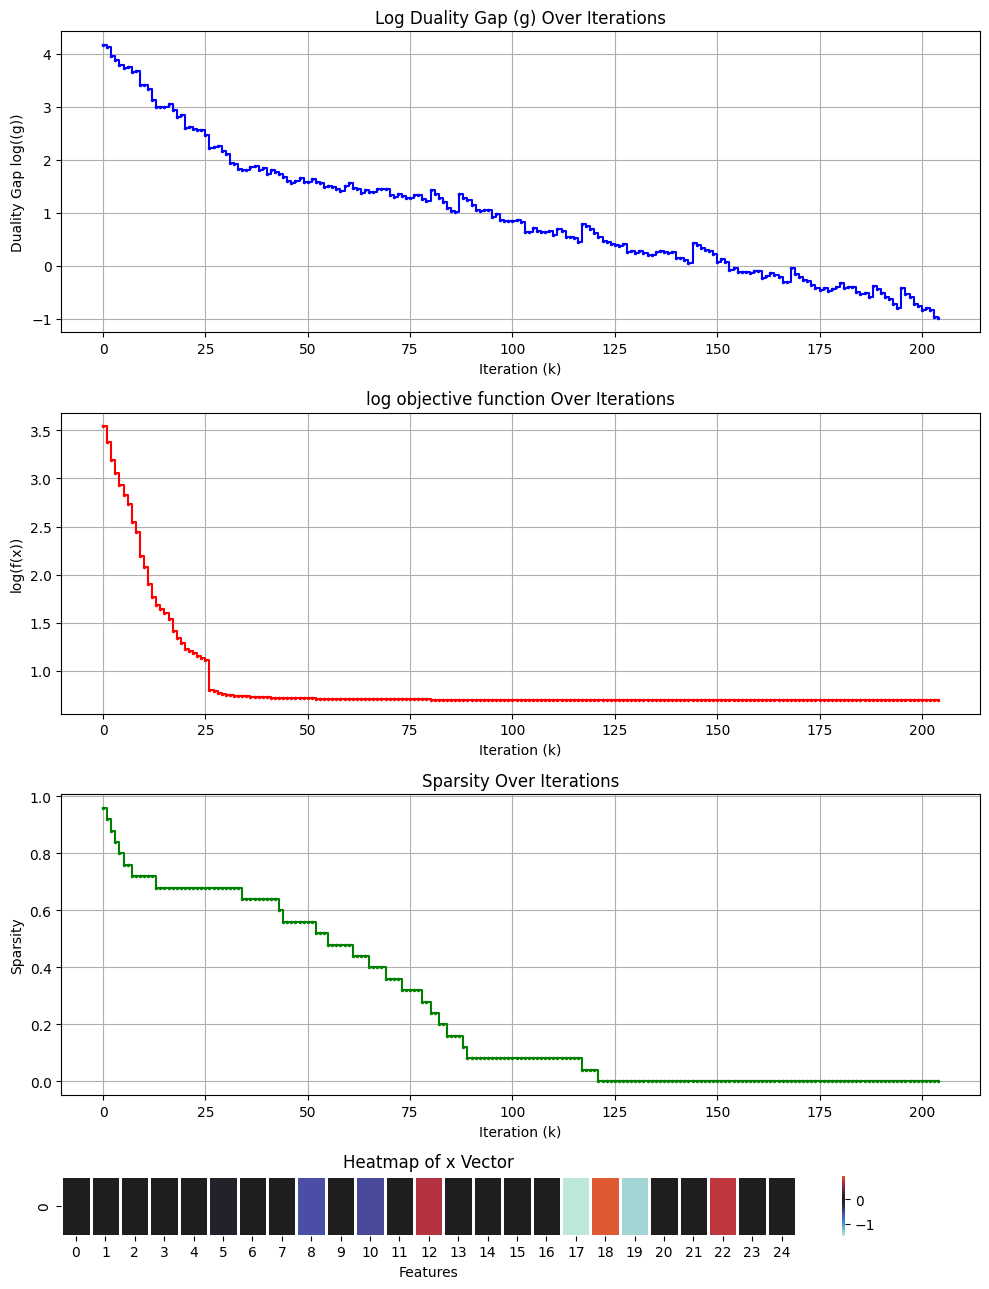

Final duality gap:  0.10222306030403536
Final objective function value:  4.985883984100975
CPU time:  0.22973700000000008
iterations:  205
Zero elements in x:  0
Sparsity:  0.0


In [70]:
model_away = Frank_Wolfe(tau=10, iter=400, verbose=False, alpha_search='armijo', e=0.1, alg='away-steps')
model_away.fit(A_test, b_test)

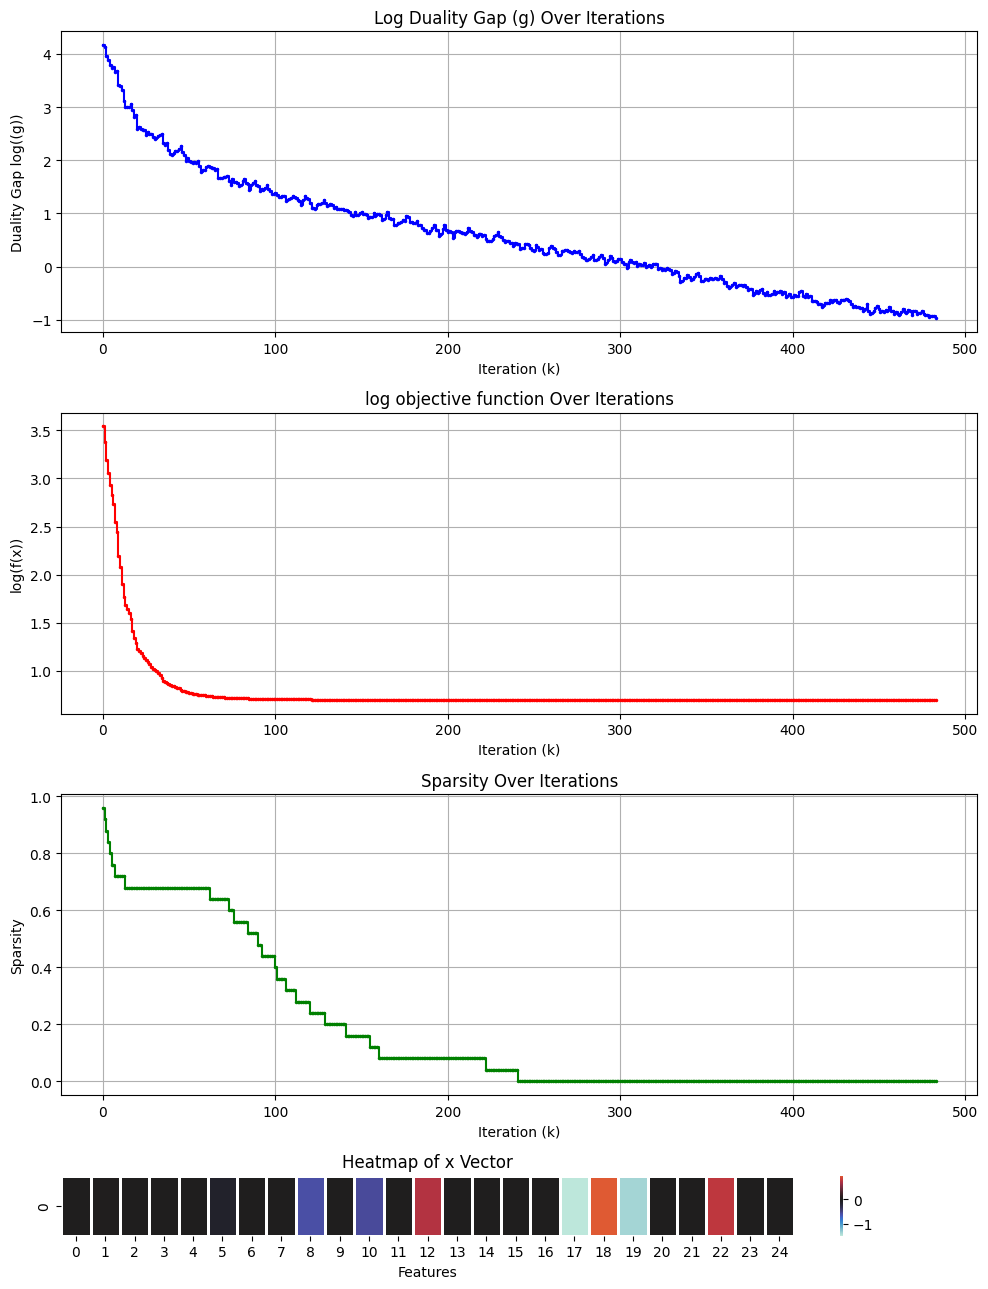

Final duality gap:  0.1061199735780871
Final objective function value:  4.985885064610687
CPU time:  0.47770880000000027
iterations:  484
Zero elements in x:  0
Sparsity:  0.0


In [6]:
model = Frank_Wolfe(10, iter=1000, verbose=False, alpha_search='armijo', e=0.1, alg='original')
model.fit(A_test, b_test)

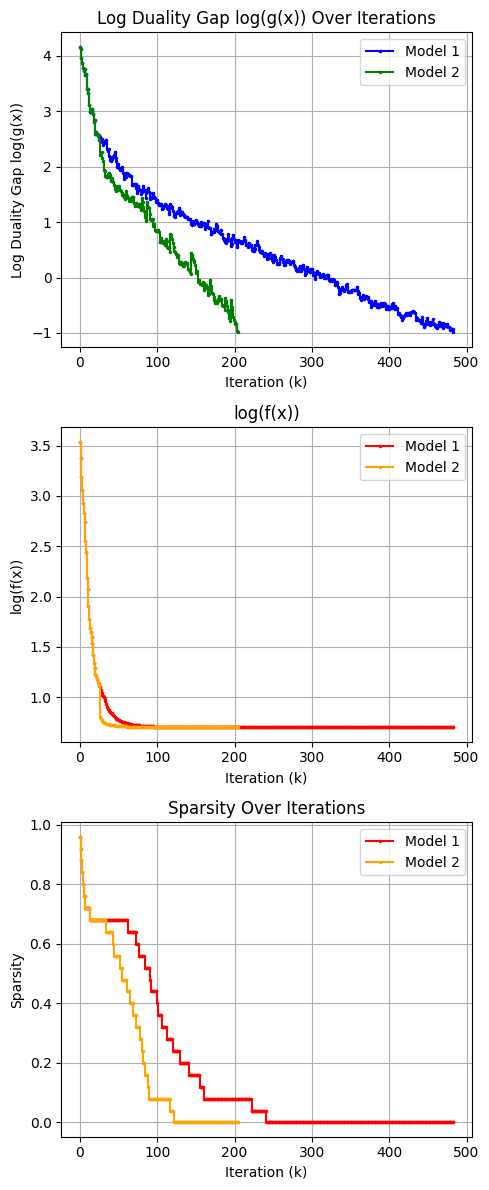

CPU time model 1:  0.47770880000000027
CPU time model 2:  0.2064674000000002


In [7]:
model.compare(model_away)

In [8]:
taus = [0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 10, 50, 100]

In [9]:
get_info(taus, "original", A_test, b_test)

tau:  0.5 	iter:  5 	CPU:  0.006936599999999515 	Sparsity:  0.92
tau:  0.75 	iter:  6 	CPU:  0.004658599999999069 	Sparsity:  0.92
tau:  1 	iter:  119 	CPU:  0.11355350000000008 	Sparsity:  0.88
tau:  1.5 	iter:  108 	CPU:  0.08352449999999934 	Sparsity:  0.84
tau:  2 	iter:  54 	CPU:  0.03642840000000014 	Sparsity:  0.8
tau:  2.5 	iter:  2000 	CPU:  1.2777496 	Sparsity:  0.76
tau:  3 	iter:  2000 	CPU:  1.3698598999999998 	Sparsity:  0.72
tau:  5 	iter:  2000 	CPU:  1.3859502000000017 	Sparsity:  0.72
tau:  10 	iter:  484 	CPU:  0.42710450000000044 	Sparsity:  0.0
tau:  50 	iter:  116 	CPU:  0.10560510000000001 	Sparsity:  0.0
tau:  100 	iter:  137 	CPU:  0.14860710000000132 	Sparsity:  0.0


In [10]:
get_info(taus, "away-steps", A_test, b_test)

tau:  0.5 	iter:  5 	CPU:  0.015022200000000652 	Sparsity:  0.92
tau:  0.75 	iter:  6 	CPU:  0.008758300000000219 	Sparsity:  0.92
tau:  1 	iter:  10 	CPU:  0.006678200000001411 	Sparsity:  0.88
tau:  1.5 	iter:  11 	CPU:  0.007384599999999963 	Sparsity:  0.84
tau:  2 	iter:  19 	CPU:  0.014312800000000792 	Sparsity:  0.8
tau:  2.5 	iter:  24 	CPU:  0.014179200000000947 	Sparsity:  0.76
tau:  3 	iter:  26 	CPU:  0.014854299999999654 	Sparsity:  0.72
tau:  5 	iter:  40 	CPU:  0.024514699999999223 	Sparsity:  0.72
tau:  10 	iter:  205 	CPU:  0.19478819999999963 	Sparsity:  0.0
tau:  50 	iter:  119 	CPU:  0.12669819999999987 	Sparsity:  0.0
tau:  100 	iter:  131 	CPU:  0.1413530000000005 	Sparsity:  0.0


In [11]:
# function to standardize datasets

def standardize(A):
    means = np.mean(A, axis=0)
    stds = np.std(A, axis=0)
    A_std = (A - means) / stds
    return A_std

First real dataset. 
This dataset is related to white wine variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.). 
The task is to be able to identify the quality of the wine given the data provided. The authors specify that they are unsure whether all the features are relevant, making it a good candidate to test our algorithm, that should enforce sparsity in the solution. 

In [12]:
df_wine = pd.read_csv("winequality-white.csv", sep=';')

In [13]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


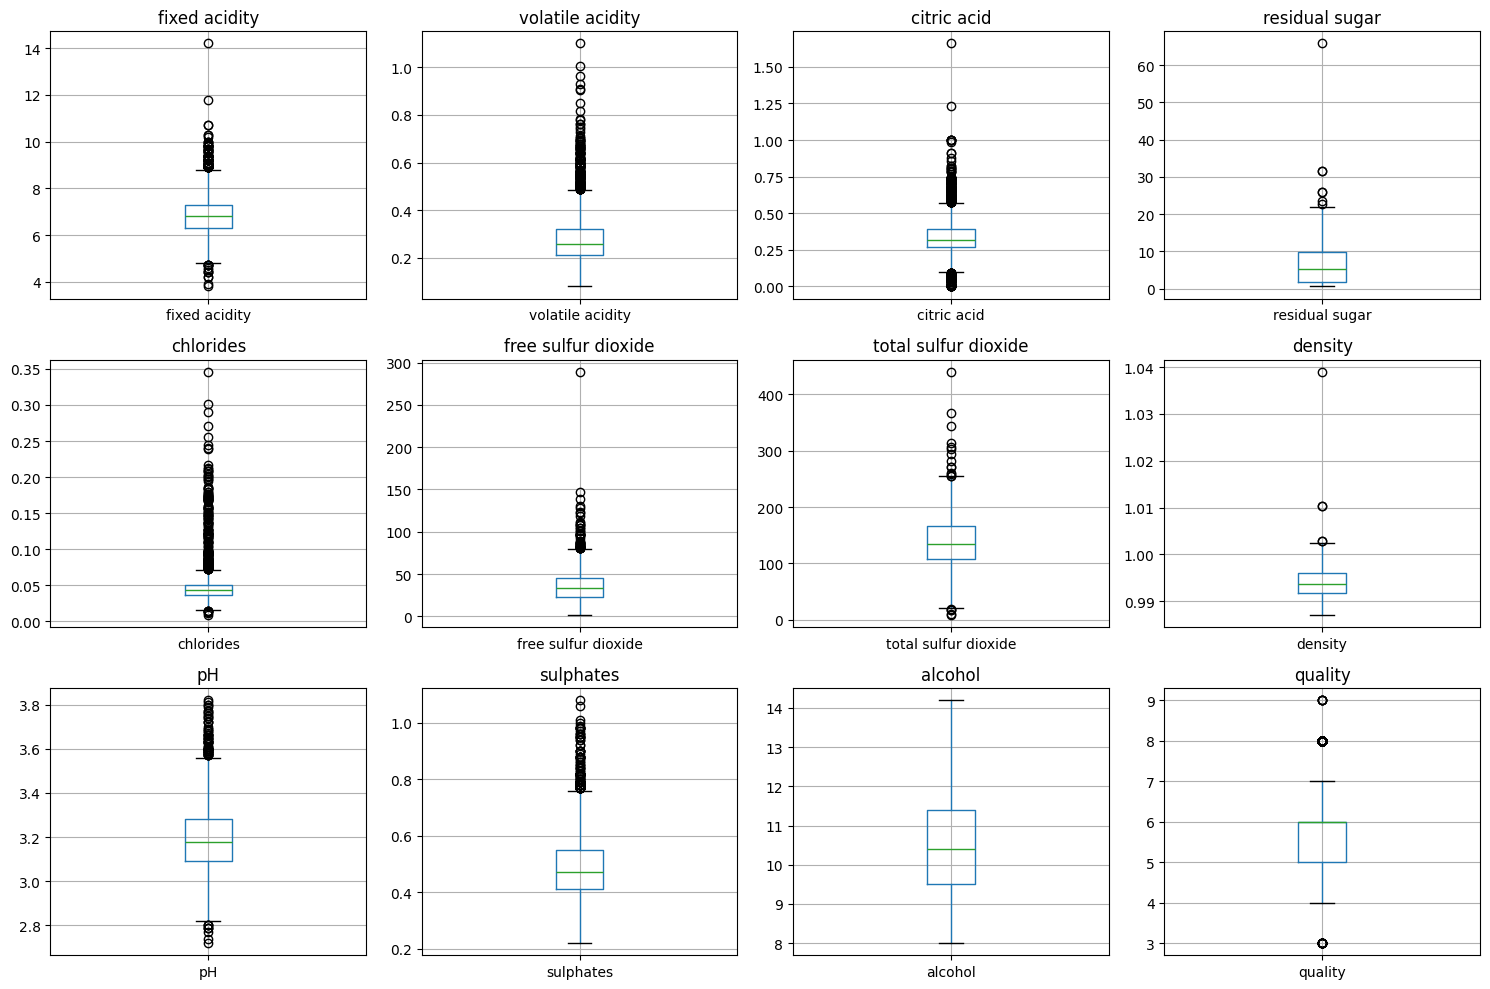

In [14]:
rows = 3
cols = 4  

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < len(df_wine.columns):
        df_wine.boxplot(column=df_wine.columns[i], ax=ax)
        ax.set_title(df_wine.columns[i])
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()

We perform some basic data cleaning to remove the most notable outliers

In [15]:
df_wine_filt = df_wine[df_wine['fixed acidity'] <= 11]
df_wine_filt = df_wine[df_wine['citric acid'] <= 1.10]
df_wine_filt = df_wine[df_wine['residual sugar'] <= 60]
df_wine_filt = df_wine[df_wine['free sulfur dioxide'] <= 250]
df_wine_filt = df_wine[df_wine['total sulfur dioxide'] <= 400]
df_wine_filt = df_wine[df_wine['density'] <= 1.03]

In [16]:
df_wine_filt = standardize(df_wine_filt)
b_w = df_wine_filt['quality']
A_w = df_wine_filt.drop(['quality'], axis= 1)

In [17]:
# convert to numpy arrays
A_w = A_w.to_numpy()
b_w = b_w.to_numpy()

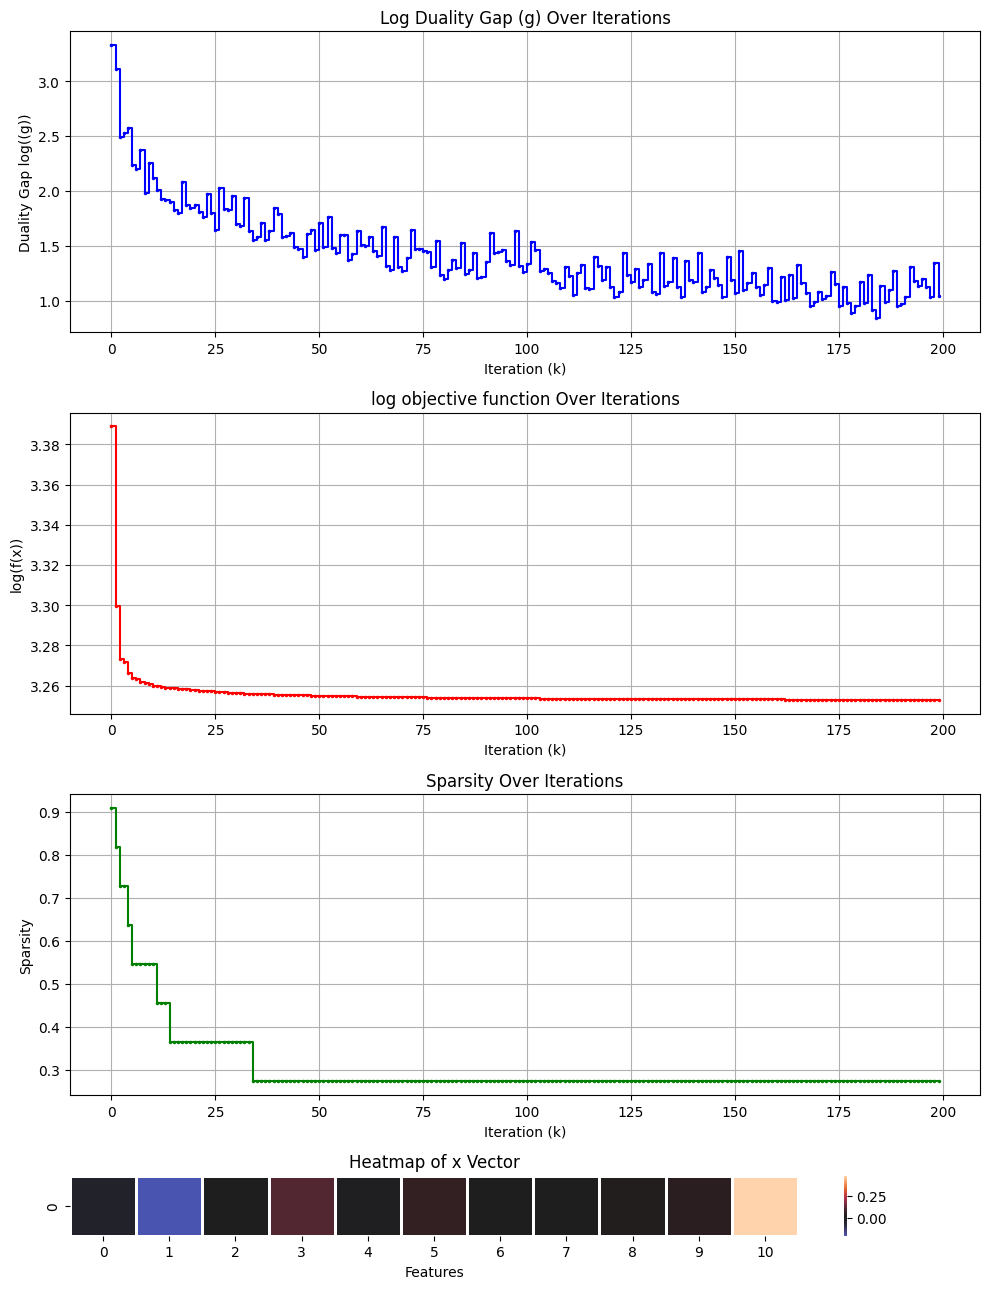

Final duality gap:  10.982171278652068
Final objective function value:  1790.0735039820536
CPU time:  0.17636499999999877
iterations:  200
Zero elements in x:  3
Sparsity:  0.2727272727272727


In [18]:
model_w_original = Frank_Wolfe(tau=1, iter=200, verbose=False, alpha_search='armijo', e=1)
model_w_original.fit(A_w, b_w)

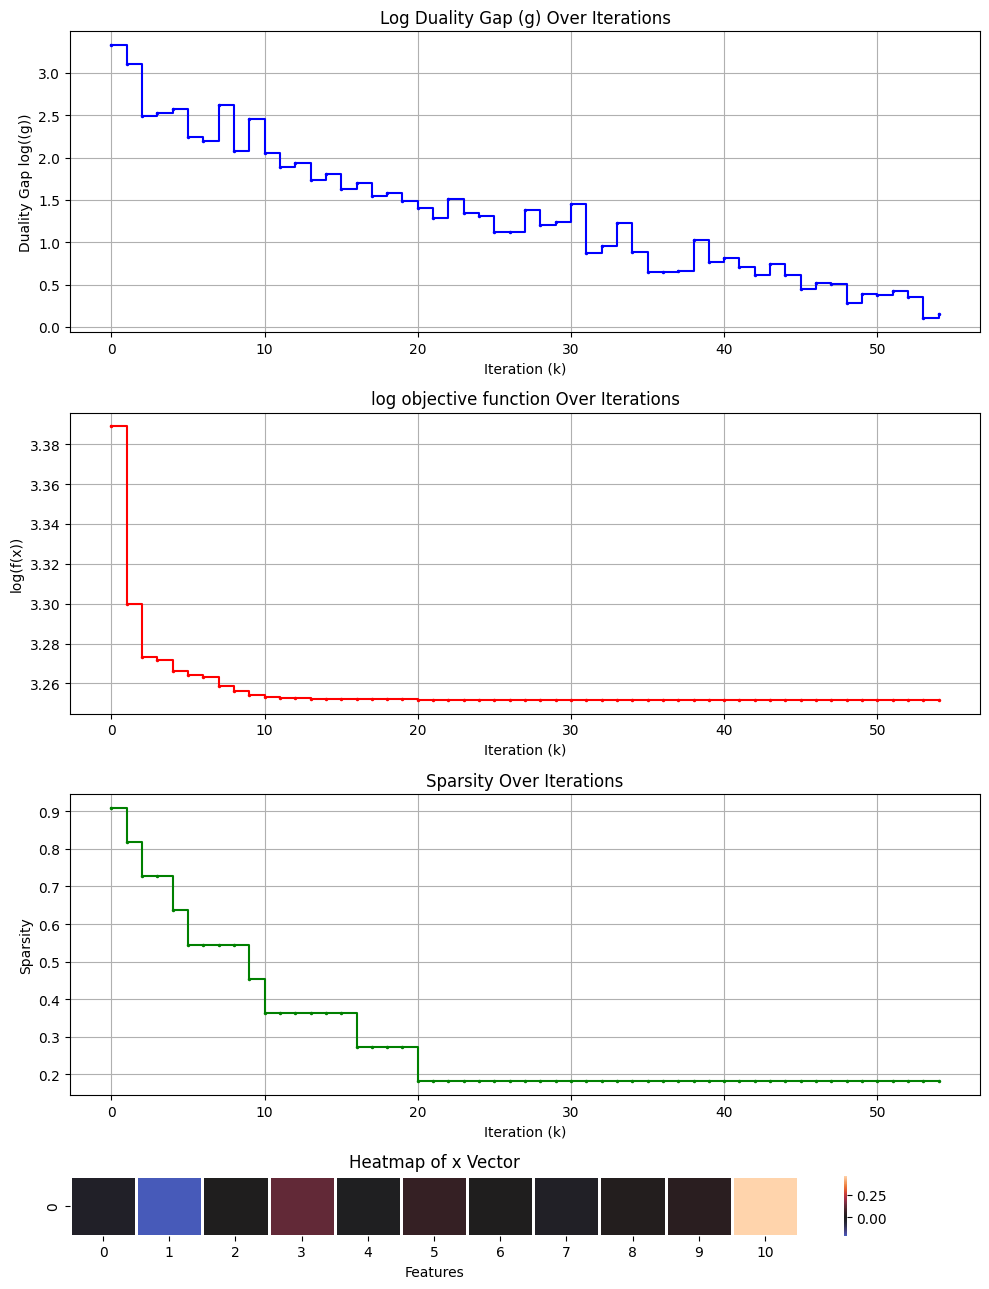

Final duality gap:  1.406999589106995
Final objective function value:  1785.546069797506
CPU time:  0.07342539999999786
iterations:  55
Zero elements in x:  2
Sparsity:  0.18181818181818182


In [19]:
model_w_away = Frank_Wolfe(tau=1, iter=200, verbose=False, alpha_search='armijo',  e=1, alg="away-steps")
model_w_away.fit(A_w, b_w)

In [20]:
model_w_away.x

array([[-0.03678507],
       [-0.20870713],
       [ 0.        ],
       [ 0.12687004],
       [-0.01703655],
       [ 0.05656121],
       [ 0.        ],
       [-0.03065112],
       [ 0.01809145],
       [ 0.03697139],
       [ 0.46832603]])

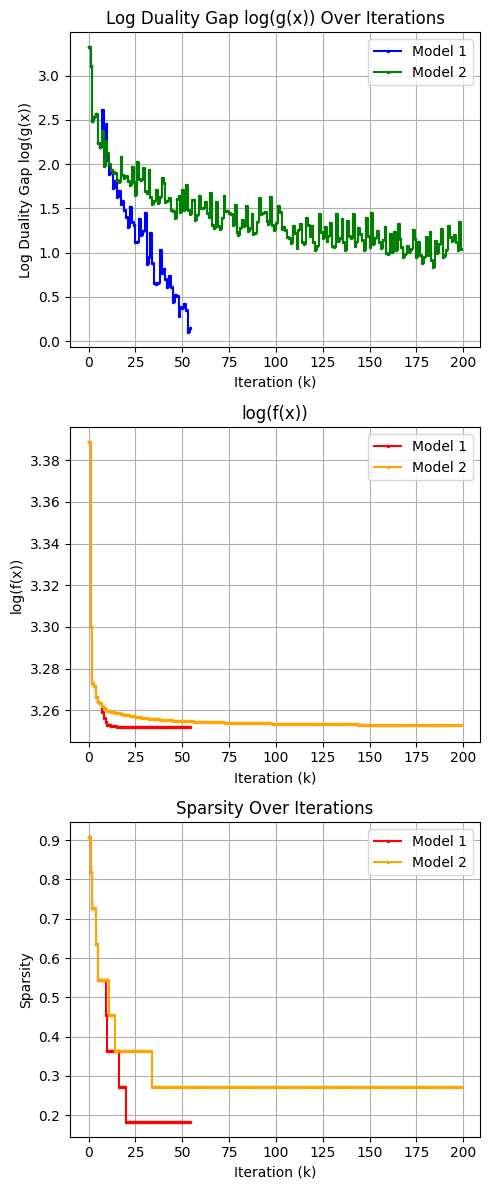

CPU time model 1:  0.07342539999999786
CPU time model 2:  0.17636499999999877


In [21]:
model_w_away.compare(model_w_original)

In [23]:
vector = np.arange(0.5, 0.5 + 50 * 0.05, 0.05)

In [24]:
get_info([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5], "original", A_w, b_w)

tau:  0.5 	iter:  6 	CPU:  0.01222399999999979 	Sparsity:  0.7272727272727273
tau:  0.6 	iter:  335 	CPU:  0.35743150000000057 	Sparsity:  0.5454545454545454
tau:  0.7 	iter:  2000 	CPU:  1.9361157999999996 	Sparsity:  0.36363636363636365
tau:  0.8 	iter:  2000 	CPU:  2.0242673999999994 	Sparsity:  0.36363636363636365
tau:  0.9 	iter:  2000 	CPU:  2.4833713999999993 	Sparsity:  0.2727272727272727
tau:  1 	iter:  2000 	CPU:  2.1310257999999997 	Sparsity:  0.18181818181818182
tau:  2 	iter:  2000 	CPU:  2.095016300000001 	Sparsity:  0.0
tau:  5 	iter:  1693 	CPU:  2.3313853999999985 	Sparsity:  0.0


In [25]:
get_info([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5], "away-steps", A_w, b_w)

tau:  0.5 	iter:  7 	CPU:  0.011787599999998122 	Sparsity:  0.7272727272727273
tau:  0.6 	iter:  22 	CPU:  0.026172899999998833 	Sparsity:  0.5454545454545454
tau:  0.7 	iter:  25 	CPU:  0.021132900000001342 	Sparsity:  0.36363636363636365
tau:  0.8 	iter:  33 	CPU:  0.02610960000000162 	Sparsity:  0.36363636363636365
tau:  0.9 	iter:  33 	CPU:  0.027075099999997576 	Sparsity:  0.2727272727272727
tau:  1 	iter:  89 	CPU:  0.08044479999999865 	Sparsity:  0.18181818181818182
tau:  2 	iter:  404 	CPU:  0.3863158999999996 	Sparsity:  0.09090909090909091
tau:  5 	iter:  1309 	CPU:  1.8989644000000006 	Sparsity:  0.0


Second Dataset:

In [26]:
df_por = pd.read_csv("student-por.csv", sep=';')

In [27]:
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [28]:
df_por.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In this case, we will need to label encode some of the variables

In [29]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = df_por.select_dtypes(include=['object']).columns

le = LabelEncoder()

for col in categorical_cols:
    df_por[col] = le.fit_transform(df_por[col])


In [30]:
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,4,0,11,11
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,2,9,11,11
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,6,12,13,12
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,0,14,14,14
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,0,11,13,13


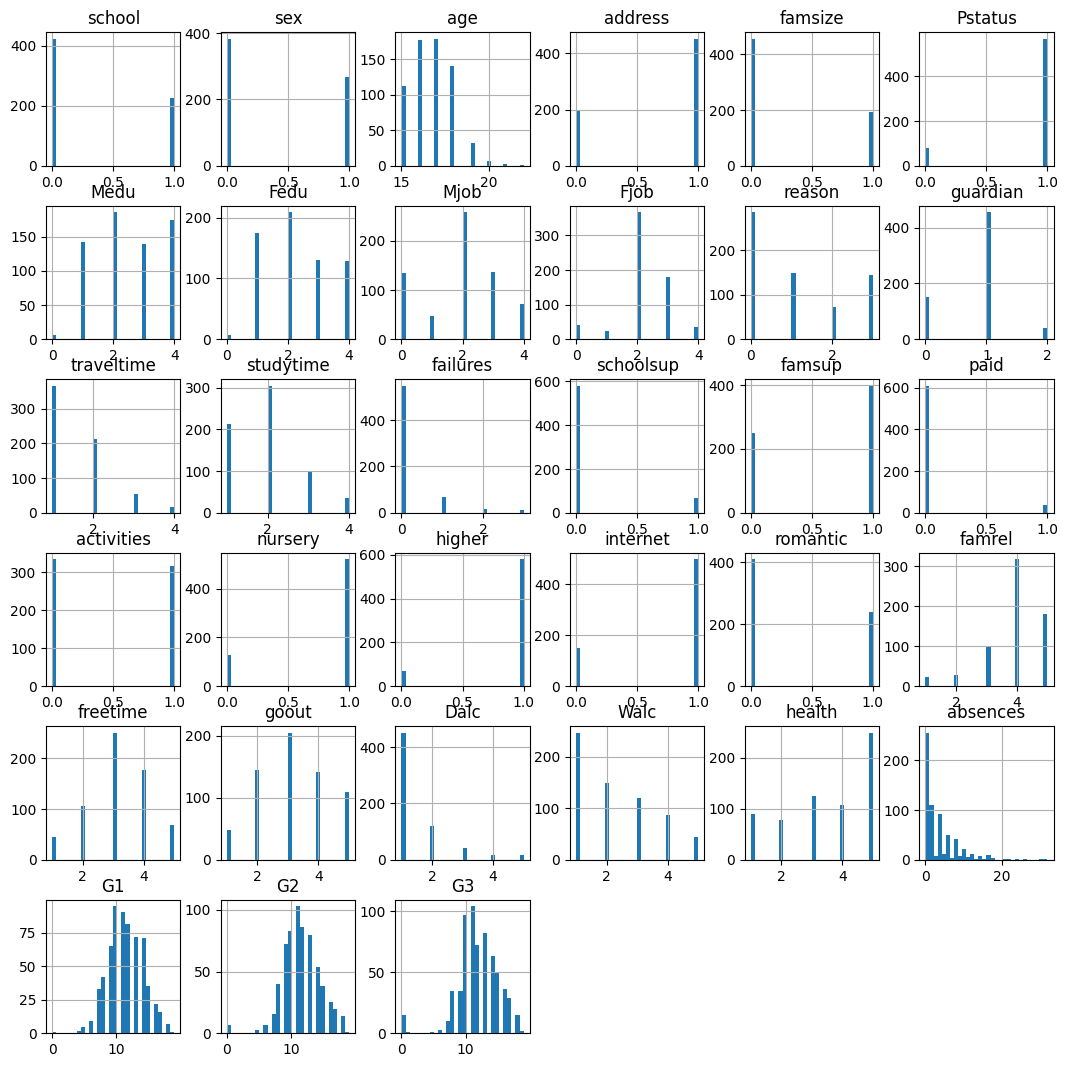

In [31]:
df_por.hist(bins=30, figsize=(13,13))
plt.show()

In [32]:
df_por = standardize(df_por)
b_por = df_por['G3']
A_por = df_por.drop(['G1', 'G2', 'G3'], axis= 1)

In [33]:
A_por = A_por.to_numpy()
b_por = b_por.to_numpy()

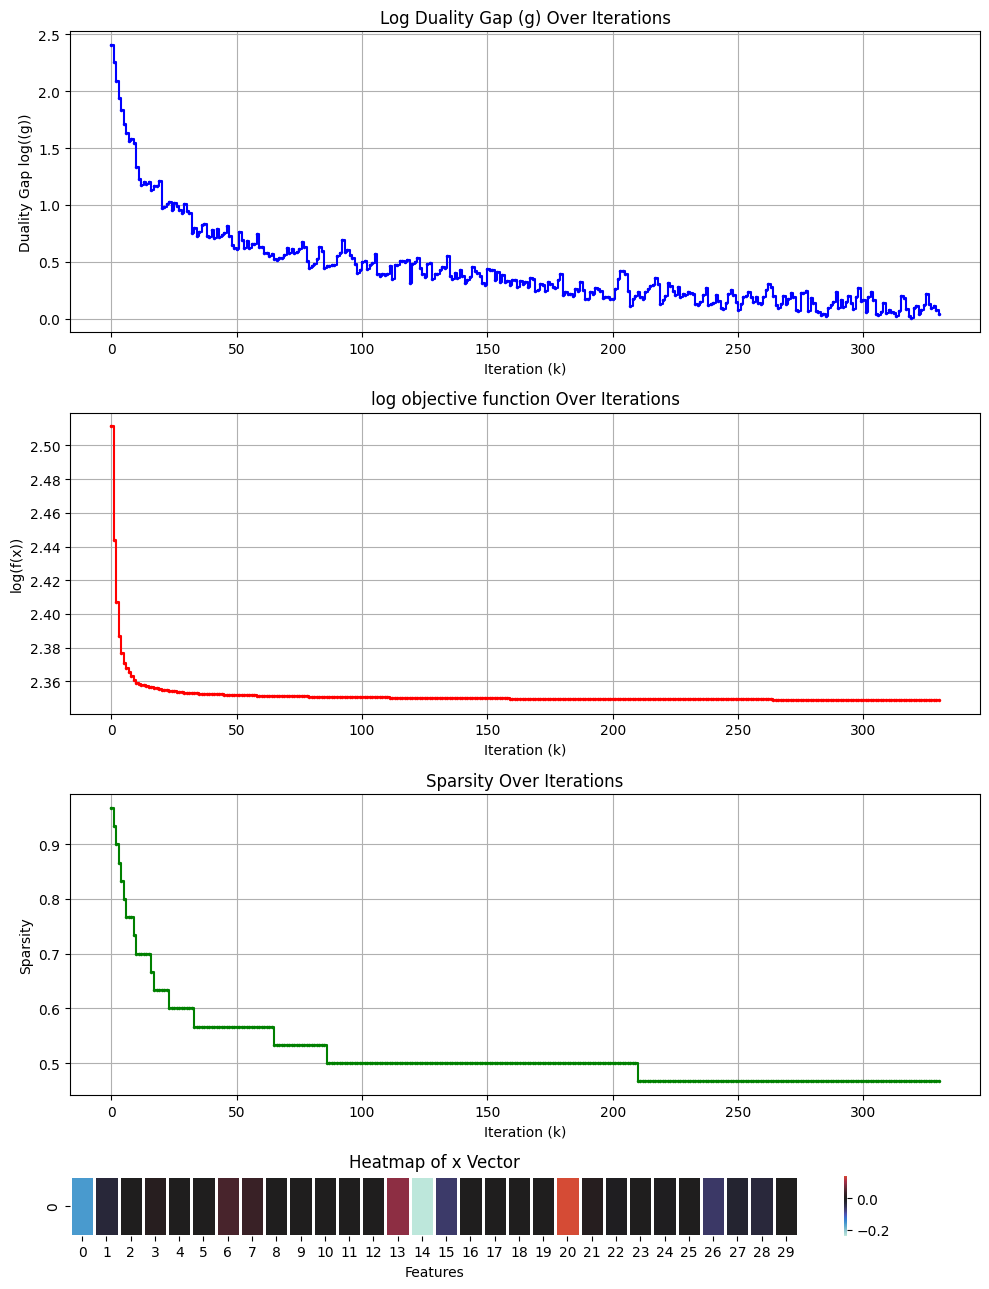

Final duality gap:  1.1084625183388634
Final objective function value:  223.38858676851322
CPU time:  0.1779017000000067
iterations:  331
Zero elements in x:  14
Sparsity:  0.4666666666666667


In [59]:
model_por_original = Frank_Wolfe(tau=1, iter=2000, verbose=False, alpha_search='armijo', e=1)
model_por_original.fit(A_por, b_por)

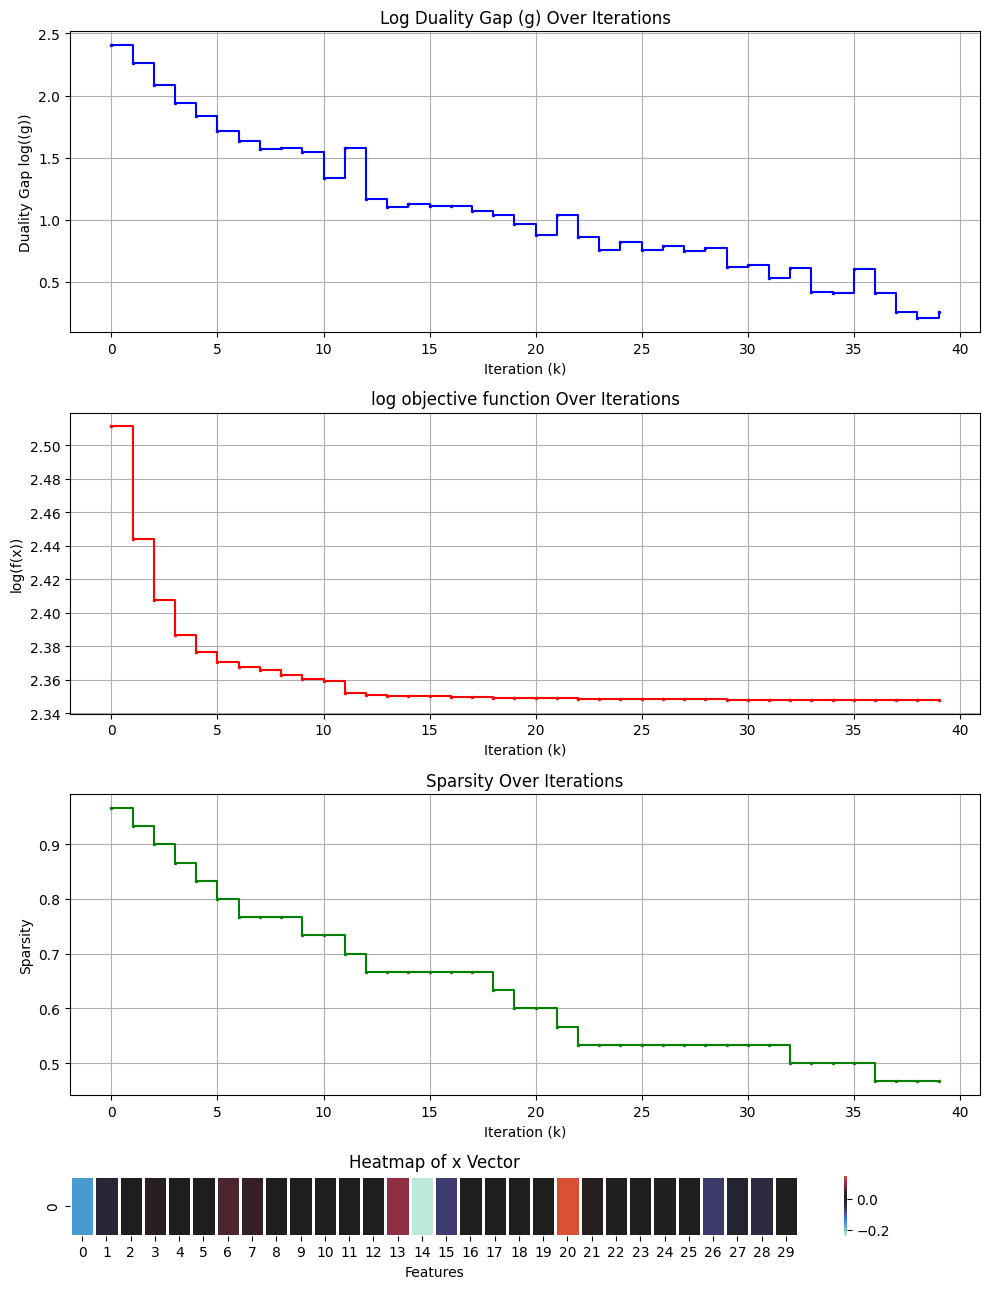

Final duality gap:  1.8164131704739963
Final objective function value:  222.8887242037317
CPU time:  0.027587400000001594
iterations:  40
Zero elements in x:  14
Sparsity:  0.4666666666666667


In [60]:
model_por_away = Frank_Wolfe(tau=1, iter=2000, verbose=False, alpha_search='armijo',  e=1, alg="away-steps")
model_por_away.fit(A_por, b_por)

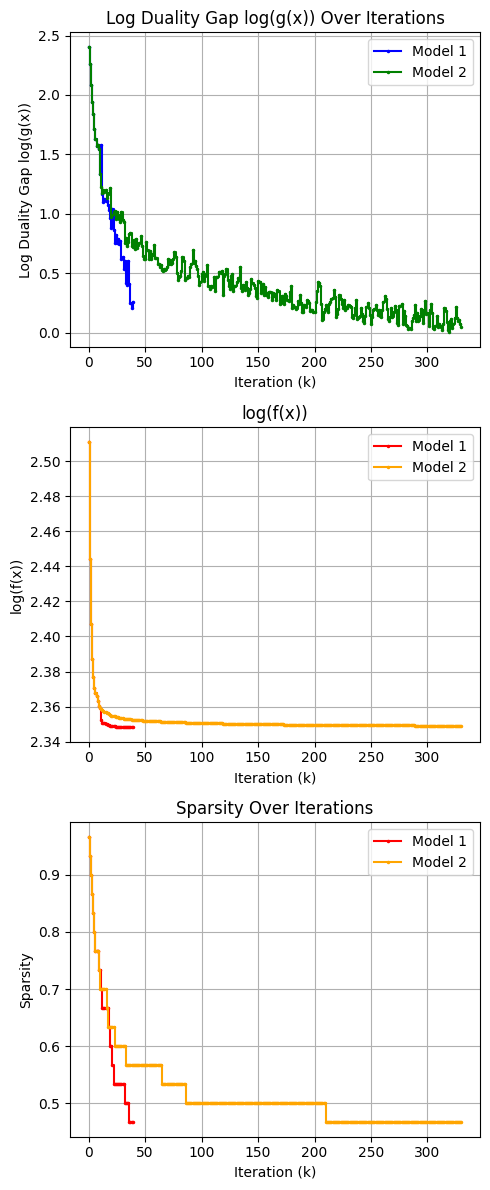

CPU time model 1:  0.027587400000001594
CPU time model 2:  0.1779017000000067


In [61]:
model_por_away.compare(model_por_original)

In [37]:
df_h = pd.read_csv("housing.csv", sep=',')

In [38]:
df_h.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [39]:
df_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [40]:
df_h = df_h.dropna()

In [41]:
df_h.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [42]:
categorical_cols = df_h.select_dtypes(include=['object']).columns

le = LabelEncoder()

for col in categorical_cols:
    df_h[col] = le.fit_transform(df_h[col])

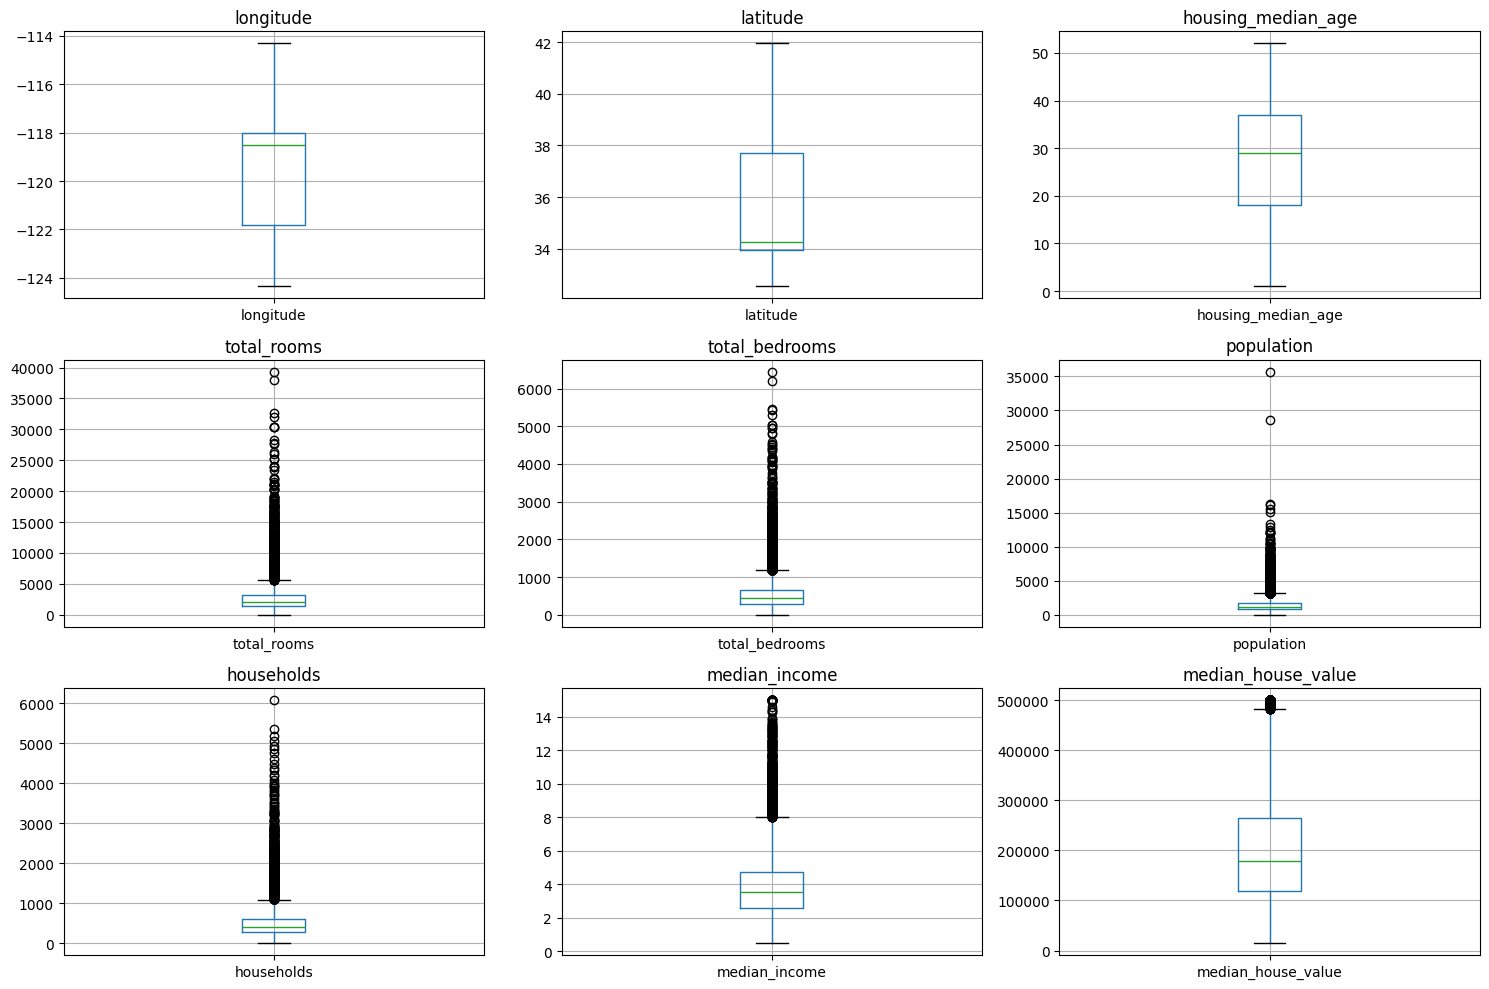

In [47]:
rows = 3
cols = 3  

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < len(df_h.columns):
        df_h.boxplot(column=df_h.columns[i], ax=ax)
        ax.set_title(df_h.columns[i])
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()

In [48]:
df_h = standardize(df_h)
b_h = df_h['median_house_value']
A_h = df_h.drop(['median_house_value'], axis= 1)

b_h = b_h.to_numpy()
A_h = A_h.to_numpy()

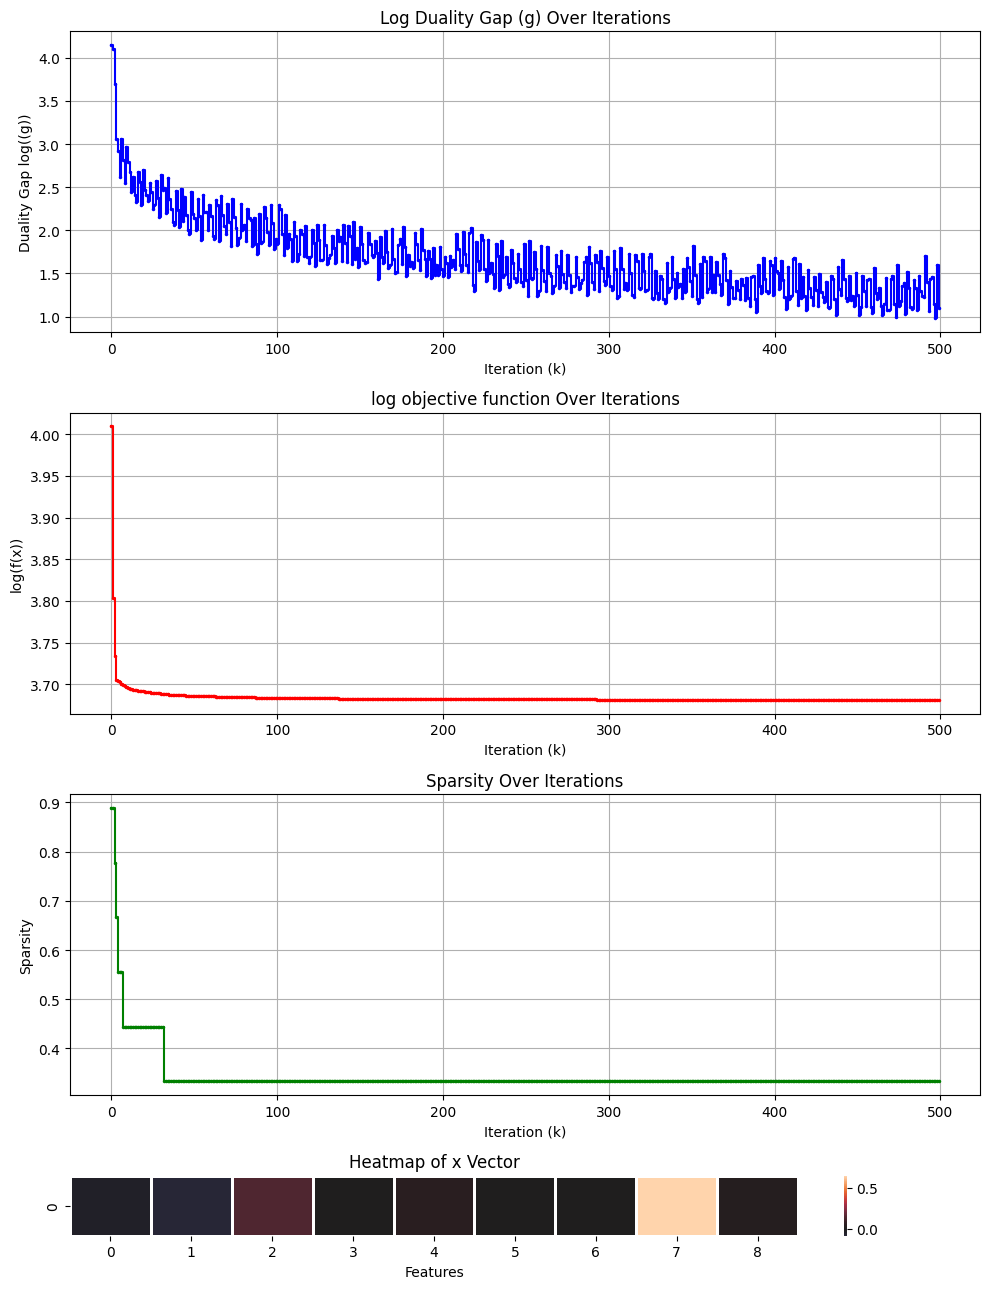

Final duality gap:  12.442547152568167
Final objective function value:  4800.655737970804
CPU time:  1.4193771999999996
iterations:  500
Zero elements in x:  3
Sparsity:  0.3333333333333333


In [65]:
model_h_original = Frank_Wolfe(tau=1, iter=500, verbose=False, alpha_search='armijo', e=1)
model_h_original.fit(A_h, b_h)

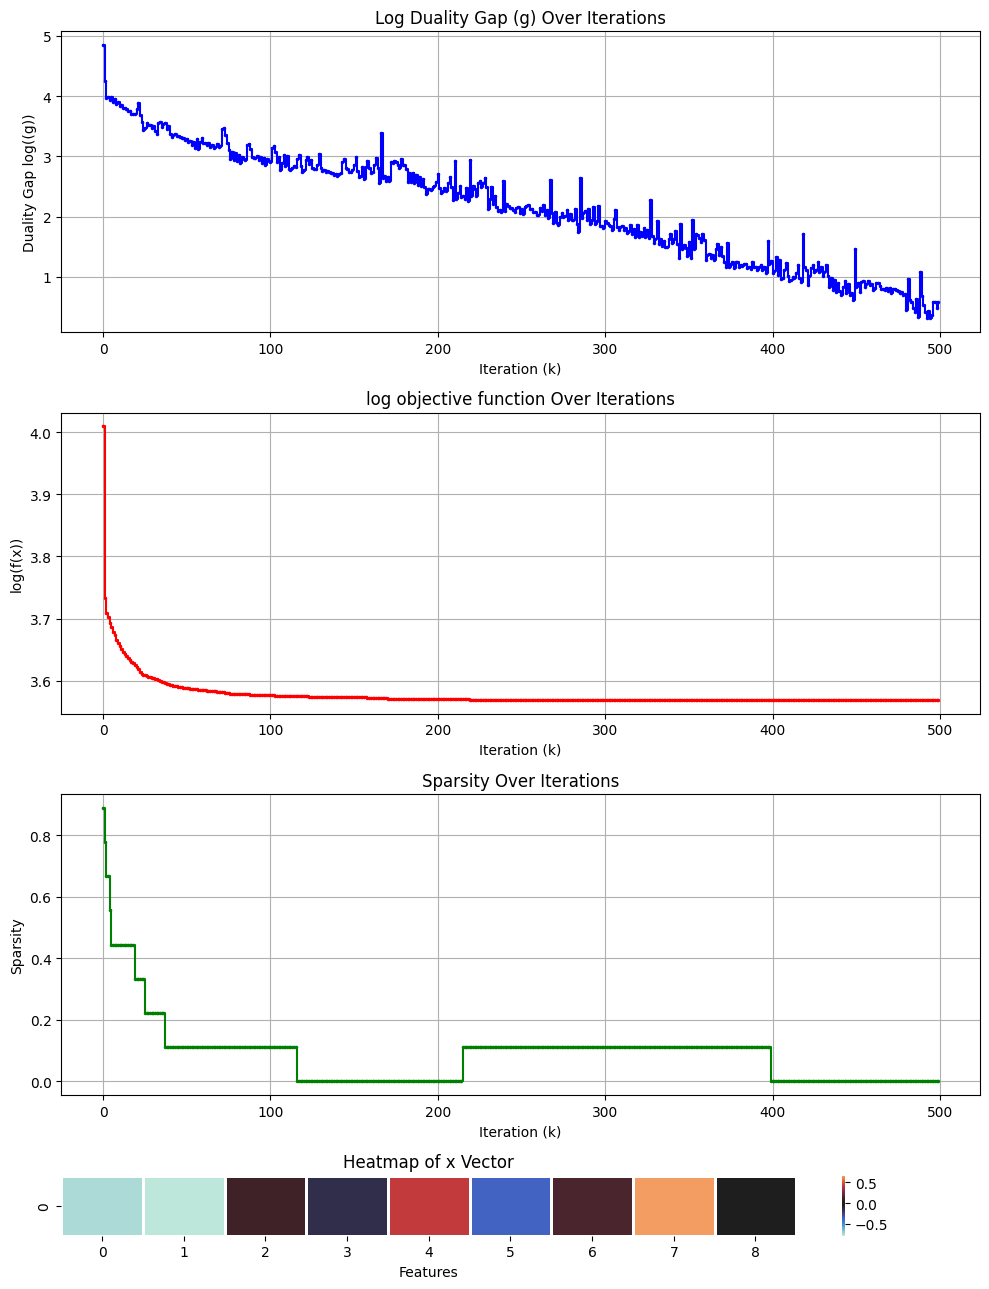

Final duality gap:  3.8565862777320805
Final objective function value:  3709.490892258436
CPU time:  1.9903238999999928
iterations:  500
Zero elements in x:  0
Sparsity:  0.0


In [68]:
model_h_away = Frank_Wolfe(tau=5, iter=500, verbose=False, alpha_search='armijo', e=1, alg='away-steps')
model_h_away.fit(A_h, b_h)

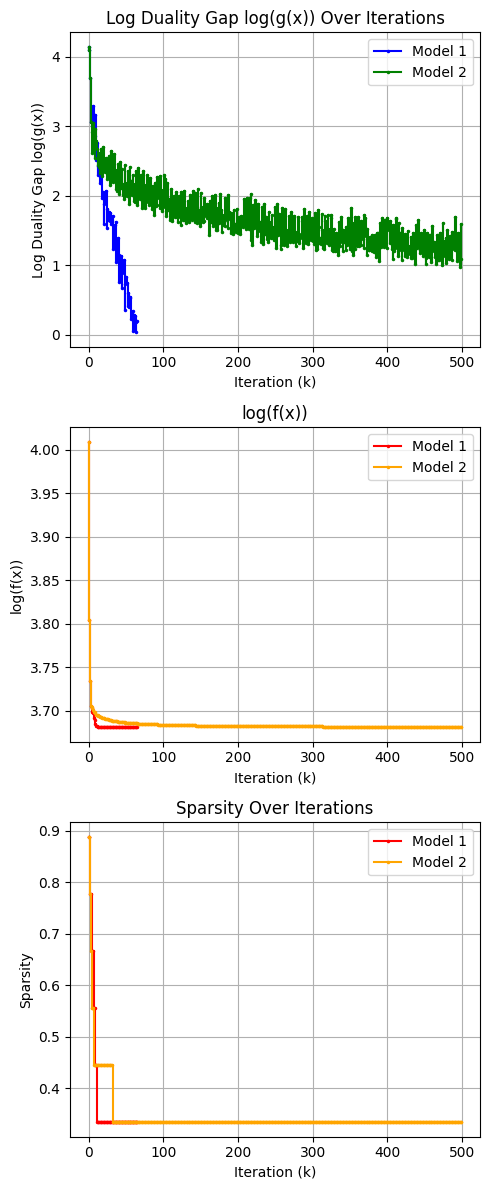

CPU time model 1:  0.179496400000005
CPU time model 2:  1.4193771999999996


In [67]:
model_h_away.compare(model_h_original)